# Description
This notebook runs MCMC on the cultivation model.

In [1]:
import numpy
import json
import pymc3
import pathlib
from IPython.display import display

import theano

# workaround for https://github.com/pymc-devs/aesara/issues/395
theano.config.mode = theano.Mode().excluding("local_useless_subtensor")

import calibr8
import murefi

import models

DP_FIGURES = pathlib.Path("figures")
DP_PROCESSED = pathlib.Path("processed")

### Read models and dataset

In [2]:
cm_biomass = models.get_biomass_model()
cm_glucose = models.get_glucose_model()
model = models.MonodModel()
dataset = murefi.load_dataset(DP_PROCESSED / "cultivation_dataset.h5")
theta_mapping = models.get_parameter_mapping()
theta_mapping

ParameterMapping(28 replicates, 5 inputs, 31 free parameters)

### Make `start_dict` for MAP-estimation from MLE fit
The following cell prepares a dictionary of parameter values near the MLE - we use this to initialize MAP estimation later.

In [3]:
with open(DP_PROCESSED / "full_dataset_mle.json") as jfile:
    mle_dict = json.load(jfile)

X_values = [item for (key, item) in mle_dict.items() if "X0" in key]
mcmc_dict = {
    "X0_mu": numpy.mean(X_values),
    "F_offset": numpy.clip([v / numpy.mean(X_values) for v in X_values], 0.8, 1.5),
}
for key, item in mle_dict.items():
    if not "X0" in key:
        mcmc_dict[key] = item
start_dict = mcmc_dict.copy()
start_dict

{'X0_mu': 0.27794886065833785,
 'F_offset': array([0.83035787, 1.20667553, 1.08343887, 0.95989416, 0.89789533,
        0.90816162, 0.86742931, 1.06850055, 1.28243436, 1.04676626,
        0.91839778, 0.90654109, 0.92049472, 0.86265084, 1.49567635,
        1.12943297, 0.98270593, 0.90213849, 0.9261479 , 0.86346156,
        0.86650529, 1.36711016, 1.13484077, 0.98896736, 0.92233141,
        0.89371225, 0.86965513, 0.89767614]),
 'S0': 16.921204160580245,
 'Y_XS': 0.6725556283205485,
 'mu_max': 0.4250821973525337}

### Functions for model graph, find MAP and sampling

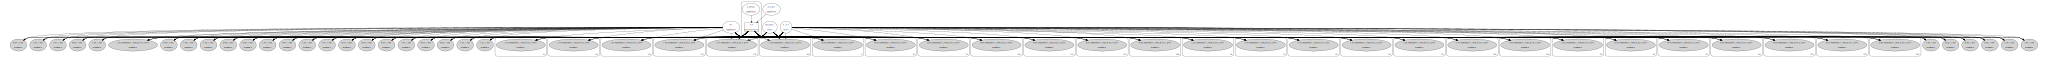

In [4]:
objective = murefi.objectives.for_dataset(
    dataset=dataset,
    model=model,
    parameter_mapping=theta_mapping,
    calibration_models=[cm_glucose, cm_biomass],
)

with pymc3.Model(coords={"replicate": list(dataset.keys())}) as pmodel:
    # Specify a hyperprior on the initial biomass group mean:
    # + centered on the planned inoculation density of 0.25 g/L in the main culture
    # + with a 10 % standard deviation to account for pipetting errors
    X0_mu = pymc3.Lognormal("X0_mu", mu=numpy.log(0.25), sd=0.10)

    # Model the relative offset of initial biomass between each well and the group mean
    # with a relative pipetting error of 20 %
    F_offset = pymc3.Lognormal("F_offset", mu=0, sd=0.20, dims=("replicate",))

    # Thereby, the initial biomass in each well is the product
    # of group mean and relative offset:
    X0 = pymc3.Deterministic("X0", X0_mu * F_offset, dims=("replicate",))

    # Combine the priors into a dictionary
    theta = {
        "S0": pymc3.Lognormal("S0", mu=numpy.log(20), sigma=0.10),
        "Y_XS": pymc3.Beta("Y_XS", mu=0.6, sd=0.05),
        "mu_max": pymc3.Beta("mu_max", mu=0.4, sd=0.1),
        # unpack the vector of initial biomasses into individual scalars
        **{f"X0_{rid}": X0[w] for w, rid in enumerate(dataset.keys())},
    }
    L = objective(theta)


graph = pymc3.model_to_graphviz(pmodel)
graph.render(filename=DP_FIGURES / "cultivation_model", format="pdf", cleanup=True)
display(graph)

### Find the MAP estimate
Initializing DE-MCMC-Z near the MAP helps convergence, because it is faster for the chains to diverge into the typical set than to converge to it from an arbitrary coordinate in the parameter space.

In [5]:
with pmodel:
    map_dict = pymc3.find_MAP(start=start_dict)

# Save it, just like we did for the MLE.
with open(DP_PROCESSED / "full_dataset_map.json", "w") as jfile:
    json.dump(
        {k: numpy.array(v).tolist() for k, v in map_dict.items()},
        jfile,
        indent=4,
    )
map_dict

{'X0_mu_log__': array(-1.28031478),
 'F_offset_log__': array([-0.06371512,  0.20641148,  0.0713428 , -0.04103351, -0.10791373,
        -0.09646118, -0.14236954,  0.00527305,  0.23011012,  0.05012561,
        -0.08396796, -0.09832237, -0.08272944, -0.14768848,  0.21124629,
         0.14479978, -0.01761951, -0.10302526, -0.07674716, -0.14667528,
        -0.14338229,  0.21858909,  0.13116835, -0.0107946 , -0.08096105,
        -0.11234068, -0.13986828, -0.10778877]),
 'S0_log__': array(2.82826909),
 'Y_XS_logodds__': array(0.71998178),
 'mu_max_logodds__': array(-0.3019183),
 'X0_mu': array(0.27794979),
 'F_offset': array([0.93827225, 1.22925891, 1.07394931, 0.95979696, 0.89770504,
        0.90804515, 0.86730069, 1.00528698, 1.25873862, 1.05140316,
        0.91946072, 0.90635667, 0.92060019, 0.86269982, 1.23521654,
        1.15580813, 0.9825348 , 0.90210419, 0.92612399, 0.86357435,
        0.86642278, 1.24431987, 1.14015971, 0.98926345, 0.92222961,
        0.89373972, 0.86947275, 0.8978172

### Run MCMC sampling
The DE-MCMC-Z sampler will be initialized at the MAP. This accelerates its convergence to the typical set.

In [6]:
with pmodel:
    idata_full = pymc3.sample(
        step=pymc3.DEMetropolisZ(
            # 10x less than the default, because some posteriors are rather narrow.
            scaling=0.0001,
            # Only the first half of tuning steps is "contaminated" by initial convergence.
            # The default of 0.9 is quite conservative about this.
            tune_drop_fraction=0.8,
        ),
        return_inferencedata=True,
        tune=50_000,
        draws=500_000,
        discard_tuned_samples=False,
        start=start_dict,
        compute_convergence_checks=False,  # Can take rather long and we do this separately anyway.
        idata_kwargs={
            # Likelihood evaluation of ODE models is really expensive.
            # Enabling it doubles the runtime, but without a progress bar!
            "log_likelihood": False
        },
    )
idata_full.to_netcdf(DP_PROCESSED / "full_posterior.nc")

Multiprocess sampling (3 chains in 3 jobs)
DEMetropolisZ: [mu_max, Y_XS, S0, F_offset, X0_mu]


Sampling 3 chains for 50_000 tune and 500_000 draw iterations (150_000 + 1_500_000 draws total) took 28652 seconds.


WindowsPath('processed/full_posterior.nc')

In [7]:
%load_ext watermark
%watermark

Last updated: 2021-05-09T23:22:00.317277+02:00

Python implementation: CPython
Python version       : 3.7.9
IPython version      : 7.19.0

Compiler    : MSC v.1916 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : Intel64 Family 6 Model 158 Stepping 10, GenuineIntel
CPU cores   : 6
Architecture: 64bit

